In [1]:
import re
from pprint import pprint

import matplotlib.pyplot as plt
import nltk
import numpy as np
import pandas as pd
import seaborn as sns
import spacy
from gensim.models import KeyedVectors, Word2Vec
from nltk.corpus import stopwords
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics.pairwise import cosine_similarity
from textblob import TextBlob
from wordcloud import WordCloud
import os
from collections import defaultdict


pd.set_option('display.max_colwidth', None)
SPECIAL_CHARS = '[^A-Za-z0-9 ]+'
STOP_WORDS = stopwords.words('english')

# 2. Functions

In [2]:
def preprocess_text(text):
    """
    Take out stopwords.
    Take out punctuations and special characters.
    """
    SPECIAL_CHARS = '[^A-Za-z0-9 ]+'
    STOP_WORDS = stopwords.words('english')
    text = text.lower().split(' ')
    temp = [word for word in text if word not in STOP_WORDS]
    text = ' '.join(temp)
    text = re.sub(SPECIAL_CHARS, '', text)
    return text

In [3]:
def tokenise(doc):
    return [token.text for token in nlp(doc)]

In [4]:
def tokenise_lemma(doc):
    """
    Use spacy as the nlp object to tokenise each doc
    Lemmatise each words
    """
    return ' '.join([token.lemma_ for token in nlp(doc)])

In [5]:
# this is one way to get each title's vector representation
# more investagtion is needed later.

def get_vectors(first_map, second_map):
    """
    Use tokenised words to get vectors representations from the pretrained model (i.e. second_map).
    Average the vector representation of the description as the representation of the document 
    (i.e. each movie title's representation is the mean of vectors of each words in its description)
    """
    first_vec  = dict()
    for title, description in first_map.items():
        temp = list()
        for element in description: #element = tokenised words
            try:
                temp.append(second_map[element]) #secondmap is w2v model which should have a responding word vecotr for the tokenise word
            except KeyError:
                pass
        first_vec[title] = np.mean(temp, axis=0)
    
    return first_vec

In [6]:
def search(name, df):
    return df.loc[df['title'].str.lower()==name.lower()]

In [7]:
def get_topN_similar(lookup_id, title_vec, df, N=10):
    lookup_id = lookup_id.lower()
    sim = list()
    lookup_map = title_vec
    subject_map = title_vec 
        
    for uid, vec in lookup_map.items():
        thisSim = cosine_similarity(vec.reshape(1, -1), subject_map[lookup_id].reshape(1, -1))
        org = search(uid, df).originals.values.tolist()[0]
        gen = search(uid, df).genres.values.tolist()[0]
        year = search(uid, df).year.values.tolist()[0]
        sim.append((uid, thisSim[0][0], org, gen, year))
    sim = sorted(sim, key=lambda x: x[1], reverse=True)[:N+1]
    returnDf = pd.DataFrame(columns=['title','similarity','originals','genres', 'year'],
                           data = sim)
    return returnDf

In [8]:
def get_most_similar(lookup_id, title_vec, df):

    sim = list()
    lookup_map = title_vec
    subject_map = title_vec 
        
    for uid, vec in lookup_map.items():
        thisSim = cosine_similarity(vec.reshape(1, -1), subject_map[lookup_id].reshape(1, -1))
        org = search(uid, df).originals.values
        gen = search(uid, df).genres.values
        sim.append((uid, thisSim[0][0], org, gen))

    return sorted(sim, key=lambda x: x[1], reverse=True)

In [9]:
def filter_df(keyword):
    """
    Return a dataframe with the filtered result.
    The input value is case-insensitive. 
    """
    if type(keyword) == list:
        return netflixDf.loc[netflixDf['title'].isin(keyword)]
    else:
        return netflixDf.loc[netflixDf['title'].str.lower().isin([keyword.lower()])]

In [10]:
def markerX(key, values):
    return netflixDf.loc[netflixDf[key].str.lower().isin(values)].sort_values(by='pca_2', ascending=False)

def others(key, values):
    return netflixDf.loc[~netflixDf[key].str.lower().isin(values)]

# 3. Analyse Pipeline

## Terms explained
Document -> a bunch of texts <br>
Corpus -> a bunch of documents <br>
Vectors -> a mathematically convenience representation of a document (a bunch of textx) <br>
Models -> an algorithm for transforming vectors from one representation to another <br>

## Load the spacy pretrained model

In [11]:
# use pre-trained corpus to help tokenise words
nlp = spacy.load('en_core_web_sm')

## Analyse Descriptive Data

In [12]:
movieDf = pd.read_csv('movie_dataset_july18.csv', usecols=['title','genres','year','type','originals','everything'])

## Create Corpus and apply word embedding

In [13]:
movieTkDocs = [tokenise(doc) for doc in movieDf.everything.values.tolist()] #tokenise 

In [14]:
# mapping out the title and each description. so later on i can search 
movieMap = dict(zip(movieDf['title'].str.lower().tolist(), movieTkDocs))
# lower the title (easy for search)

In [15]:
path = "GoogleNews-vectors-negative300.bin"
w2v = KeyedVectors.load_word2vec_format(path, binary=True)
# It is much faster take less than 2 minutes

In [16]:
movieTitleVec = get_vectors(movieMap, w2v)

## top 10 movies analysis

In [17]:
top_10_movie = [
    'Bird Box',
    'Murder Mystery',
    'Triple Frontier',
    'The Perfect Date',
    'Tall Girl',
    'The Highwaymen',
    'Secret Obsession',
    'Always Be My Maybe',
    'Otherhood',
    'FYRE: The Greatest Party That Never Happened'
]

In [18]:
top10_and_10sim = pd.DataFrame()
for movie in top_10_movie:
    df = get_topN_similar(movie, movieTitleVec, movieDf)
    top10_and_10sim = top10_and_10sim.append(df, ignore_index=True)

In [19]:
# Only the silence_2019 has name issue. Handled it seperately.
t = top10_and_10sim.title.tolist()
t[1] = 'the silence'
top10_and_10sim['title'] = t

In [20]:
# top10_and_10sim.to_csv('similar.csv')

In [24]:
import omdb
import os
OMDB_API_KEY = os.environ.get('OMDB_API_KEY')
omdb.set_default('apikey', OMDB_API_KEY)

In [28]:
titles_for_omdb = top10_and_10sim.title.tolist()
year_for_omdb = top10_and_10sim.year.tolist()

### Manually change incorrect information

In [29]:
year_for_omdb[29] = 2016
titles_for_omdb[39] = '#TemanTapiMenikah'
titles_for_omdb[67] = 'silent hill: revelation'
year_for_omdb[85] = 2014
titles_for_omdb[98] = 'the meyerowitz stories'
titles_for_omdb[99] = 'fyre'
titles_for_omdb[100] = 'theater of life'
titles_for_omdb[102] = 'woodstock'
titles_for_omdb[104] = 'Cézanne et moi'
year_for_omdb[106] = 2017
titles_for_omdb[108] = 'Todo sobre el asado'

In [30]:
def omdb_get(title,year):
    movie_info = omdb.get(title=title, year = year, fullplot = True)
    temp = pd.DataFrame(data=[movie_info])
    return temp

In [31]:
omdb_results = pd.DataFrame()
for ix in range(110):
    try:
        omdb_results = omdb_results.append(omdb_get(titles_for_omdb[ix],year_for_omdb[ix]), ignore_index=True)
    except:
        print(ix)

## 年份分析

In [32]:
year_analysis = sorted(dict(omdb_results['year'].value_counts()).items(), key=lambda x: int(x[0]))

In [33]:
year_graph = pd.DataFrame(data=year_analysis)
# year_graph.rename(columns={0:'year',1:'count'}, inplace=True)

In [34]:
def show_values_on_bars(axs, h_v="v", space=0.4):
    def _show_on_single_plot(ax):
        if h_v == "v":
            for p in ax.patches:
                _x = p.get_x() + p.get_width() / 2
                _y = p.get_y() + p.get_height()
                value = int(p.get_height())
                ax.text(_x, _y, value, ha="center") 
        elif h_v == "h":
            for p in ax.patches:
                _x = p.get_x() + p.get_width() + float(space)
                _y = p.get_y() + p.get_height()
                value = int(p.get_width())
                ax.text(_x, _y, value, ha="left", va='bottom')

    if isinstance(axs, np.ndarray):
        for idx, ax in np.ndenumerate(axs):
            _show_on_single_plot(ax)
    else:
        _show_on_single_plot(axs)

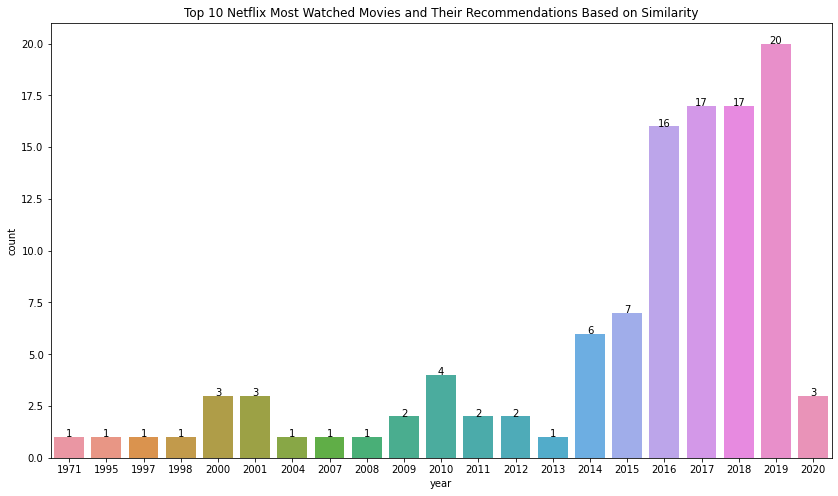

In [36]:
# year_graph.rename(columns={0:'year',1:'count'}, inplace=True)
fig, ax = plt.subplots(figsize=(14,8))
sns.barplot(x='year', y='count', data=year_graph)
show_values_on_bars(ax)
plt.title('Top 10 Netflix Most Watched Movies and Their Recommendations Based on Similarity')
plt.show()

In [37]:
# How many originals?
sim = top10_and_10sim.title.tolist()
sim = [i for i in sim if i not in [l.lower() for l in top_10_movie]]

In [38]:
orgMovie = []
for mv in sim:
    if search(mv, movieDf).originals.values == 1:
        orgMovie.append(mv)

In [39]:
(orgMovie)

['the silence',
 'the forest of love',
 'how it ends',
 'mute',
 'the crew',
 'extraction',
 'coin heist',
 'the half of it',
 'love is blind',
 'extremely wicked, shockingly evil and vile',
 'dangerous lies',
 'how to get over a breakup',
 'back to school',
 'the meyerowitz stories (new and selected)']

總共有14部電影是originals

In [274]:
mapping_for_mvCopies = defaultdict(str)
for i in range(10):
    if i != 9:
        mapping_for_mvCopies[f"mv0{str(i+1)}"] = top_10_movie[i]
    else:
        mapping_for_mvCopies["mv10"] = top_10_movie[i]

In [277]:
mv01 = omdb_results.iloc[0:11,:].copy()
mv02 = omdb_results.iloc[11:22,:].copy()
mv03 = omdb_results.iloc[22:33,:].copy()
mv04 = omdb_results.iloc[33:44,:].copy()
mv05 = omdb_results.iloc[44:55,:].copy()
mv06 = omdb_results.iloc[55:66,:].copy()
mv07 = omdb_results.iloc[66:77,:].copy()
mv08 = omdb_results.iloc[77:88,:].copy()
mv09 = omdb_results.iloc[88:99,:].copy()
mv10 = omdb_results.iloc[99:110,:].copy()

In [254]:
def year_analysis(df, save=False, title=None):
    title = df.title.tolist()[0]
    year = pd.DataFrame()
    year['year'] = df.year.value_counts().index.tolist()
    year['count'] = df.year.value_counts().tolist()
    year = year.astype(int).sort_values(by='year')
    fig, ax = plt.subplots(figsize=(10,6))
    sns.barplot(x='year', y='count', data=year, ax=ax)
    show_values_on_bars(ax)
    ax.set_title(f"Year Analysis of {title}'s top 10 similar movies")
    plt.show()
    
    if save==True:
        fileName = input()
        plt.savefig(fileName+'.png')

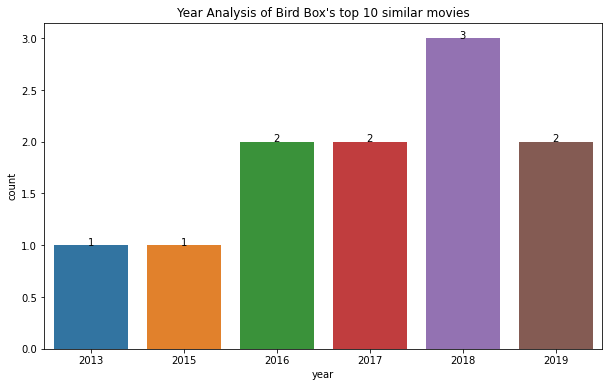

In [255]:
year_analysis(mv01)

In [256]:
def genre_analysis(df, save=False, title=None):
    title = df.title.tolist()[0]
    count = defaultdict(int)
    for g in df.genre:
        for each in g.split(','):
            each = each.rstrip().lstrip()
            count[each] += 1
    genre_analysis = pd.DataFrame(data=[count])
    genre_analysis = genre_analysis.transpose().reset_index().rename(columns={'index':'genre',0:'count'})
    genre_analysis = genre_analysis.sort_values(by='count', ascending=False)

    fig, ax = plt.subplots(figsize=(14,8))
    sns.barplot(x='genre', y='count', data=genre_analysis)
    show_values_on_bars(ax)
    plt.title(f"Genre Analysis of {title}'s top 10 similar movies'")
    plt.show()
    
    if save==True:
        fileName = input()
        plt.savefig(fileName+'.png')

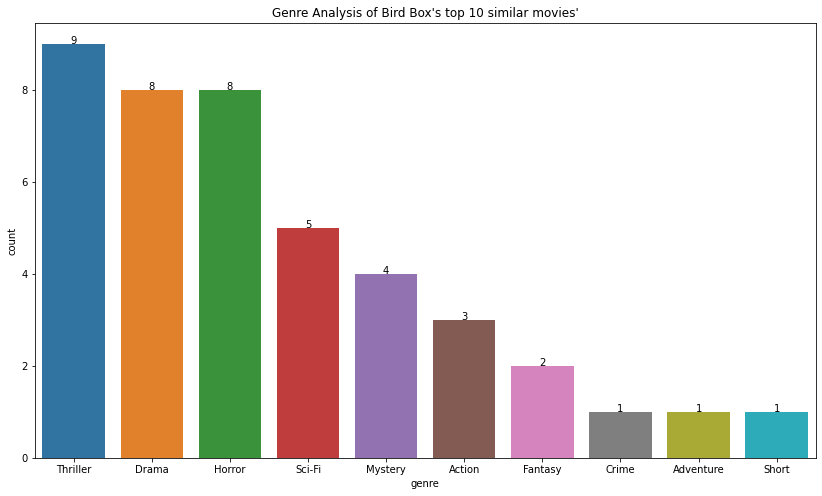

In [251]:
genre_analysis(mv01)

In [265]:
mv01[['imdb_rating','imdb_votes']]

,imdb_rating,imdb_votes
0,6.6,"261,416"
1,5.3,"33,497"
2,6.2,"40,642"
3,6.4,"1,322"
4,6.3,"2,759"
5,5.0,"42,400"
6,3.7,"8,742"
7,5.3,"5,991"
8,9.0,12
9,5.7,561


In [270]:
def imdb_analysis(df):
    
    idx = ['median', 'mean', 'max', 'min']
    cols = ['imdb_rating','imdb_votes']
    analysisDf = pd.DataFrame(index=idx, columns=cols)
    imdb = df.imdb_rating.tolist()
    imdb = [float(i) for i in imdb]
    rating_list = [np.median(imdb), np.mean(imdb), np.max(imdb), np.min(imdb)]
    rating_list = [round(k,2) for k in rating_list]
    
    votes = df.imdb_votes.tolist()
    votes = [int(j) for j in [count.replace(',','') for count in votes]]
    votes_list = [np.median(votes), np.mean(votes), np.max(votes), np.min(votes)]
    votes_list = [round(h) for h in votes_list]
    
    analysisDf['imdb_rating'] = rating_list
    analysisDf['imdb_votes'] = votes_list
    
    return analysisDf

In [271]:
imdb_analysis(mv01)

,imdb_rating,imdb_votes
median,6.20,8742
mean,5.98,42353
max,9.00,261416
min,3.70,12


In [47]:
# any originals in its 10 recommendations?
for t in mv01.title:
    if t.lower() in orgMovie:
        print(t)
#         print(mv01.loc[mv01.title==t].imdb_rating)
#         print(mv01.loc[mv01.title==t].imdb_votes)

The Silence
The Forest of Love
How It Ends
Mute


## YouTube Analysis
There are 4 movies are originals.
Go to Netflix channel to grab videoID

In [26]:
from googleapiclient.discovery import build

YOUTUBE_API_KEY = os.environ.get('YOUTUBE_API_KEY')

youtube = build('youtube','v3',developerKey=YOUTUBE_API_KEY)

In [193]:
videoIds = {
    'bird box':'o2AsIXSh2xo',
    'the silence': 'Y-ufZuqTd5c',
    'the forest of love':'ybsrYkz0V0A',
    'how it ends':'WJyyJ7lexnM',
    'mute':'ma8te7ywEio'
}

In [209]:
request = youtube.commentThreads().list(
        part="snippet,replies",
        maxResults = 100,
        videoId=videoIds['the silence'])

In [210]:
response = request.execute()

In [220]:
response['items'][0]['snippet']['topLevelComment']['snippet']['publishedAt']

'2020-07-23T20:59:07Z'

## Get Trailer Statistics first

In [206]:
statsDf = pd.DataFrame(columns=['viewCount','likeCount','dislikeCount','favoriteCount','commentCount'])
for title in videoIds.keys():
    
    rq = youtube.videos().list(
            part="statistics",
            id=videoIds[title])
    rs = rq.execute()
    stats = rs['items'][0]['statistics']
    temp = pd.DataFrame(data=[stats], columns=['viewCount','likeCount','dislikeCount','favoriteCount','commentCount'], index=[title]).astype(int)
    statsDf = statsDf.append(temp)

In [208]:
statsDf.sort_values(by='viewCount', ascending=False)

,viewCount,likeCount,dislikeCount,favoriteCount,commentCount
bird box,22914441,181424,7906,0,15937
how it ends,8321803,61675,3606,0,6140
the silence,5840873,52347,2733,0,5977
mute,2982773,14617,739,0,1327
the forest of love,178396,817,151,0,156


In [201]:
rs['items'][0]['statistics']

{'viewCount': '22914333',
 'likeCount': '181424',
 'dislikeCount': '7906',
 'favoriteCount': '0',
 'commentCount': '15937'}

In [136]:
# test to retrieve 1000 comments
def get_1kcomments(videoId, preprocess=True):
    '''
    The function returns a list of 1000 comments.
    
    '''
    rq = youtube.commentThreads().list(
            part="snippet,replies",
            maxResults = 100,
            videoId=videoId)

    comments_list = list()
    nextPageToken = list()

    for i in range(10):
        if i == 0:
            try:
                rq = youtube.commentThreads().list(
                part="snippet,replies",
                maxResults = 100,
                videoId=videoId)
                rs = rq.execute()
                for i in range(100):
                    comments_list.append(rs['items'][i]['snippet']['topLevelComment']['snippet']['textOriginal'])

                nextPageToken.append(rs['nextPageToken'])
            except:
                continue
        else:
            try:
                rq = youtube.commentThreads().list(
                part="snippet,replies",
                maxResults = 100,
                videoId=videoId,
                pageToken=nextPageToken[i-1])
                rs = rq.execute()
                for i in range(100):
                    comments_list.append(rs['items'][i]['snippet']['topLevelComment']['snippet']['textOriginal'])

                nextPageToken.append(rs['nextPageToken'])
            except:
                continue
    if preprocess == True:
        return [preprocess_text(comment) for comment in comments_list]
    else:
        return comments_list

In [172]:
def sentiment(preprocessed_comments):
    '''
    This function returns a dataframe consisting of polarity and subjectivity of the given movie reviews.
    '''
    polarity = list()
    subjectivity = list()
    for comment in preprocessed_comments:
        tb = TextBlob(comment)
        polarity.append(tb.sentiment[0])
        subjectivity.append(tb.sentiment[1])
    
    df = pd.DataFrame()
    df['polarity'] = polarity
    df['subjectivity'] = subjectivity
    return df

In [141]:
def create_wordcloud(preprocessed_comments, file_name='noID', max_font_size=150, max_words=100, background_color="white"):
    all_comments = ','.join(preprocessed_comments).replace(',', ' ').replace('movie', ' ')
    wordcloud = WordCloud(max_font_size=max_font_size, max_words=max_words, background_color=background_color).generate(all_comments)
    wordcloud.to_file(file_name+'.png')
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.show()

In [177]:
def sentiment_counts(df):
    '''
    This function returns a dataframe containing the value counts of sentiment
    '''
    sent = defaultdict(int)
    for v in df['polarity']:
        if v > 0.1:
            sent['positive'] += 1
        elif v < -0.1:
            sent['negative'] += 1
        else:
            sent['neutral'] += 1
    tempdf = pd.DataFrame(data = [sent], columns=['positive','neutral','negative'])
    tempdf = tempdf.transpose().reset_index().rename(columns={'index':'sentiment',0:'count'})
    
    return tempdf

In [183]:
def show_sentiment_counts(df):
    plt.figure(figsize=(10,6))
    sns.barplot(x='sentiment', y='count', data=df)
    plt.show()

In [186]:
def plot_sentiments(df):
    plt.figure(figsize=(10,6))
    sns.scatterplot(x='polarity', y='subjectivity', data=df)
    plt.show()

bird box

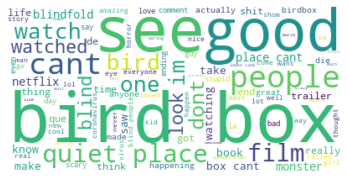

In [194]:
bb_comments = get_1kcomments(videoIds['bird box'])
bb_sent = sentiment(bb_comments)
create_wordcloud(bb_comments)

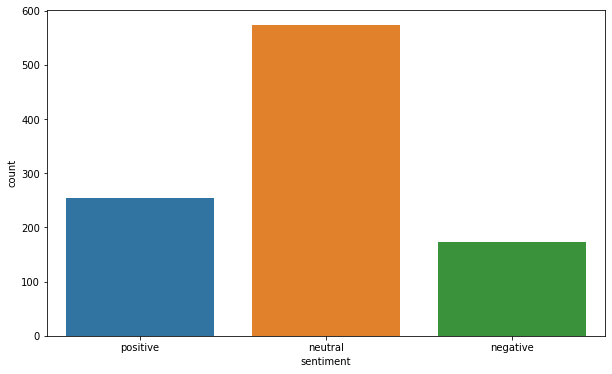

In [195]:
bb_sentCounts = sentiment_counts(bb_sent)
show_sentiment_counts(bb_sentCounts)

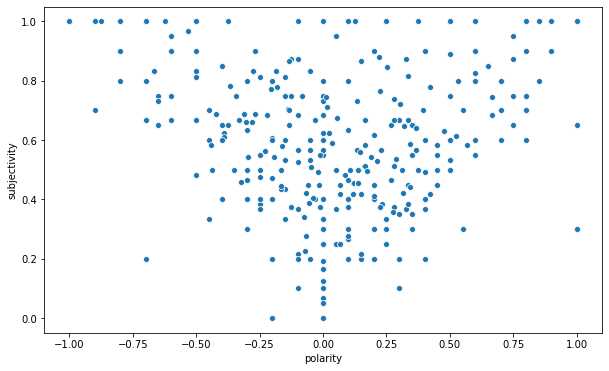

In [196]:
plot_sentiments(bb_sent)

### Mute

In [179]:
mute_comments = get_1kcomments(videoIds['mute'])

In [180]:
mute = sentiment(mute_comments)

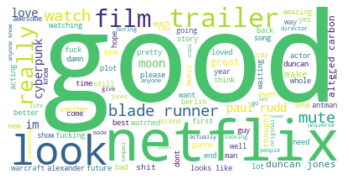

In [181]:
create_wordcloud(mute_comments)

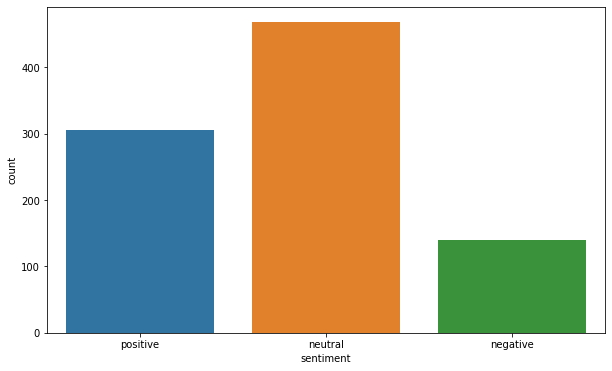

In [184]:
mute_sentCount = sentiment_counts(mute)
show_sentiment_counts(mute_sentCount)

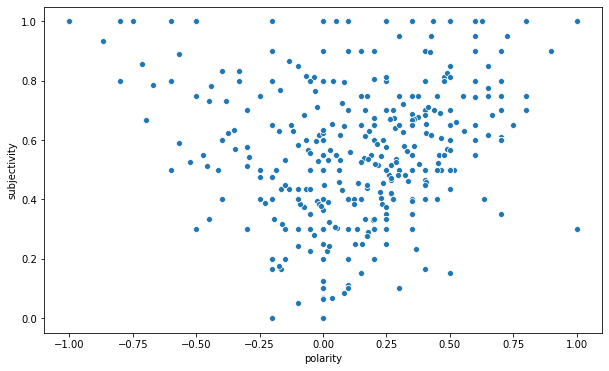

In [187]:
plot_sentiments(mute)

In [188]:
theSilence = get_1kcomments(videoIds['the silence'])

In [189]:
theSilence_sent = sentiment(theSilence)

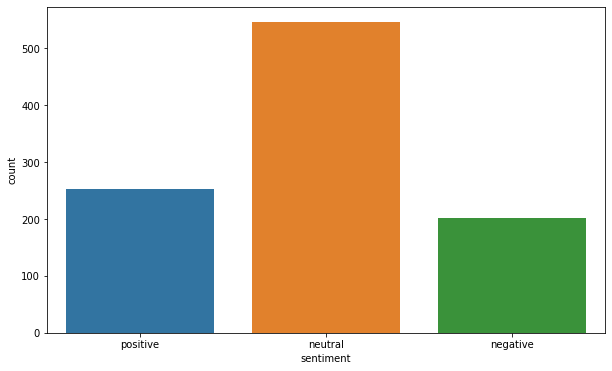

In [190]:
theSilence_sent_counts = sentiment_counts(theSilence_sent)
show_sentiment_counts(theSilence_sent_counts)

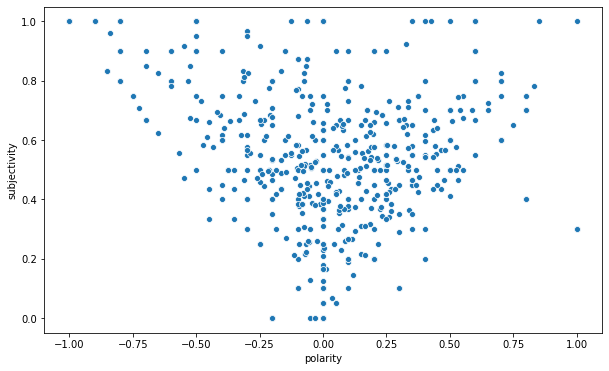

In [191]:
plot_sentiments(theSilence_sent)

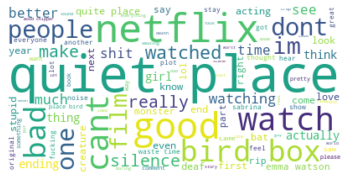

In [192]:
create_wordcloud(theSilence)

# Descriptive analysis

In [ ]:
# genres count
mv = temp.loc[temp['type']=='movie'].copy()

In [ ]:
from collections import defaultdict

In [ ]:
def count_genres(genre_list):
    """
    genre_list is pd sereis
    return a dataframe
    """
    genres_count = defaultdict(int)
    for movie in genre_list:
        for genre in movie.split(','):
            genres_count[genre] += 1
    df = pd.DataFrame(data=[genres_count])
    df = df.transpose().reset_index().rename(columns={'index':'genres',0:'counts'}).sort_values(by = 'counts', ascending=False).reset_index(drop=True)
    df['percentage'] = df['counts'].apply(lambda x: round(x/df.counts.sum(),2))
    return df

In [ ]:
def show_values_on_bars(axs, h_v="v", space=0.4):
    def _show_on_single_plot(ax):
        if h_v == "v":
            for p in ax.patches:
                _x = p.get_x() + p.get_width() / 2
                _y = p.get_y() + p.get_height()
                value = int(p.get_height())
                ax.text(_x, _y, value, ha="center") 
        elif h_v == "h":
            for p in ax.patches:
                _x = p.get_x() + p.get_width() + float(space)
                _y = p.get_y() + p.get_height()
                value = int(p.get_width())
                ax.text(_x, _y, value, ha="left", va='bottom')

    if isinstance(axs, np.ndarray):
        for idx, ax in np.ndenumerate(axs):
            _show_on_single_plot(ax)
    else:
        _show_on_single_plot(axs)

In [ ]:
mv_genres_count = count_genres(mv.genres.values.tolist())

In [ ]:
mv_org = mv.loc[mv['originals']==1].copy()

In [ ]:
mv_org_genres_count = count_genres(mv_org.genres.values.tolist())

In [ ]:
fig, ax = plt.subplots(1,2,figsize=(16,8))
bar = sns.barplot(x = 'counts',
                  y = 'genres',
                  data = mv_genres_count,
                  ax = ax[0],
                  orient = 'h')
show_values_on_bars(bar, h_v='h', space=0.3)
ax[0].set_title('The distribution of Netflix movies')

bar = sns.barplot(x = 'counts',
                  y = 'genres',
                  data = mv_org_genres_count,
                  ax = ax[1],
                  orient = 'h')
show_values_on_bars(bar, h_v='h', space=0.3)
ax[1].set_title('The distribution of Netflix Originals movies')
plt.show()

Nomalise the data and compare

In [ ]:
mv_genres_count['percentage'] = mv_genres_count['counts'].apply(lambda x: round(x/genres_df.counts.sum(),2))
mv_org_genres_count['percentage'] = mv_org_genres_count['counts'].apply(lambda x: round(x/genres_df.counts.sum(),2))

In [ ]:
fig, ax = plt.subplots(1,2,figsize=(16,8))
bar = sns.barplot(x = 'percentage',
                  y = 'genres',
                  data = mv_genres_count,
                  ax = ax[0],
                  orient = 'h')
# show_values_on_bars(bar, h_v='h', space=0.3)
ax[0].set_title('The distribution of Netflix movies')

bar = sns.barplot(x = 'percentage',
                  y = 'genres',
                  data = mv_org_genres_count,
                  ax = ax[1],
                  orient = 'h')
# show_values_on_bars(bar, h_v='h', space=0.3)
ax[1].set_title('The distribution of Netflix Originals movies')
plt.savefig('movie%.png')
plt.show()

In [ ]:
def trend_in_yearN(df ,genre , N):
    """
    return how many title's are in the given genre in the given year.
    """
    x = count_genres(df.loc[df['year']== N].genres.values.tolist())
    return x.set_index('genres').loc[genre].values.tolist()[0]

In [ ]:
def ten_year_trend(df, genre, s=2010, e=2020):
    """
    default setting start with 2010 end with 2019 (10 years).
    return a dictionary
    """
    trend = defaultdict(int)
    for key in range(s, e):
        year = str(key)
        trend[key] = trend_in_yearN(mv, genre, year)
    return trend

In [ ]:
com = ten_year_trend(mv, 'comedy')
sns.lineplot(x = list(com.keys()),
            y = list(com.values()),
            marker = 'X')

In [ ]:
def create_trend_dataframe(df, cols):
    """
    df = from which df to produce ten_year_trend
    cols = list of genres you want to include
    """
    trend_df = pd.DataFrame()
    for genre in cols:
        temp = pd.DataFrame(data=[ten_year_trend(df, genre)]).transpose().rename(columns={0:genre})
        trend_df = pd.concat([trend_df, temp], axis=1)
    return trend_df

In [ ]:
cols = ['drama','comedy','action-and-adventure','thriller','romance',
        'mystery', 'documentary','crime','family','fantasy']
trend_df = pd.DataFrame()
for genre in cols:
    temp = pd.DataFrame(data=[ten_year_trend(mv, genre)]).transpose().rename(columns={0:genre})
    trend_df = pd.concat([trend_df, temp], axis=1)

In [ ]:
create_trend_dataframe(mv, cols)

In [ ]:
genres = trend_df.columns.values.tolist()[1:6]
for gen in genres:
    sns.lineplot(x = 'index', y = gen, data = trend_df)

## TVshow

In [ ]:
temp = pd.read_csv('finaldataset_v3.csv', usecols=['title','genres','year','type','originals','cleaned'])
tv = temp.loc[temp['type']=='tvshow'].copy()

In [ ]:
tv_genres_count = count_genres(tv.genres.values.tolist())

In [ ]:
tv_org = tv.loc[tv['originals']==1].copy()
tv_org_genres_count = count_genres(tv_org.genres.values.tolist())

In [ ]:
fig, ax = plt.subplots(1,2,figsize=(16,8))
bar = sns.barplot(x = 'percentage',
                  y = 'genres',
                  data = tv_genres_count,
                  ax = ax[0],
                  orient = 'h')
# show_values_on_bars(bar, h_v='h', space=0.3)
ax[0].set_title('The distribution of Netflix Tvshow')

bar = sns.barplot(x = 'percentage',
                  y = 'genres',
                  data = tv_org_genres_count,
                  ax = ax[1],
                  orient = 'h')
# show_values_on_bars(bar, h_v='h', space=0.3)
ax[1].set_title('The distribution of Netflix Originals Tvshow')
plt.savefig('tvshow%.png')
plt.show()

In [ ]:
tv_trend = create_trend_dataframe(tv, cols).reset_index()

In [ ]:
genres = tv_trend.columns.values.tolist()[1:10]
for gen in genres:
    sns.lineplot(x = 'index', y = gen, data = tv_trend)